# Main program GAIA-NIR

## Purpose

The main program handles orchestration. \
The Spectrum class encapsulates all spectrum-related operations. \
The Parameters class handles configuration.


## Version History
- **v2.0**: Update of First functions, load and plot (2025-01-27).

Last Edited: 2025-01-24


## Flowchart of first overview of program

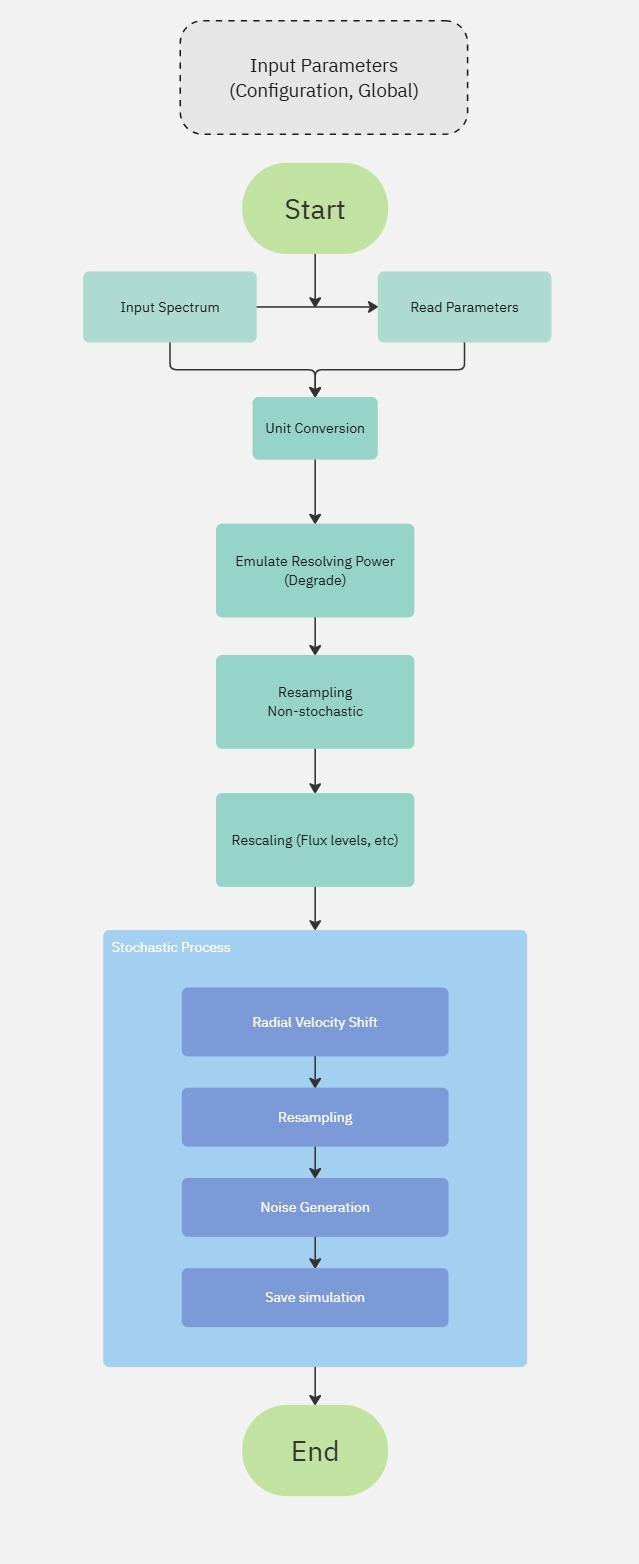

## Skeleton of Main program

2 options. \
-Make the main program into one main function with everything else defined inside it \
-Make multiple functions with the main function calling each of them. I like this approach better to make sure each one works and easier to debug if necessary.

In [2]:
pip install import-ipynb

Note: you may need to restart the kernel to use updated packages.


In [1]:
# IMPROT CLASSES OR OTHER NECESSARY FILES
import import_ipynb
from spectrum import Spectrum
from parameters import Parameters


Loading spectrum from gaia_055000450000.txt
Spectrum loaded correctly
Resampling spectrum onto new wavelength grid
Applying Gaussian convolution
Resampling and convolution completed.


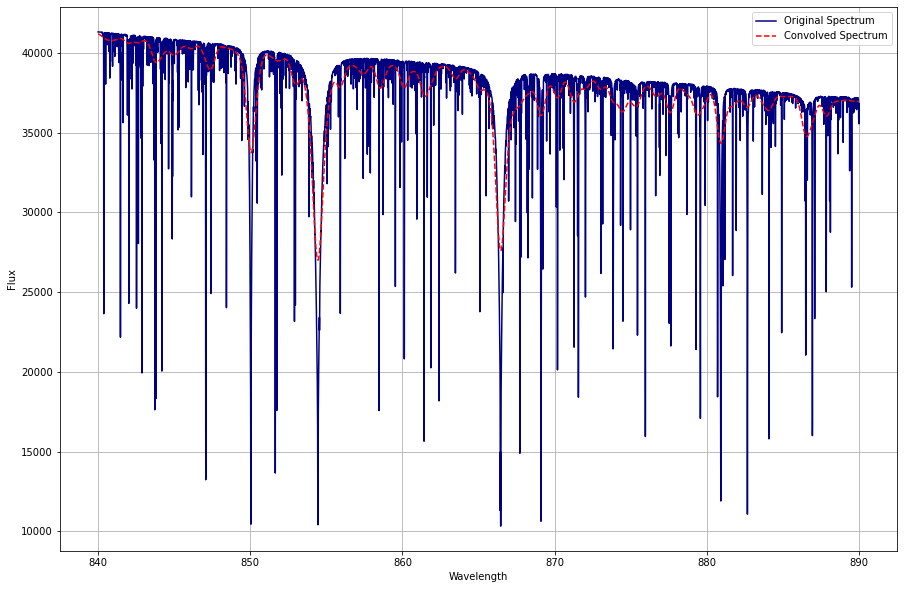

Converting units
Rescaling flux levels
Applying radial velocity shift
Resampling spectrum for stochastic process
Adding noise to spectrum
Saving spectrum to output_spectrum.txt
Simulation complete.


In [2]:
def main():
    spectrum = Spectrum()

    # Load spectrum
    spectrum.load_spectrum("gaia_055000450000.txt")
    
    # New wavelength grid
    new_wavelength_grid = np.linspace(840, 890, 1000)
    
    # Resampling and convolution
    spectrum.resample_and_convolve(new_wavelength_grid=new_wavelength_grid, sigma=5.0)
    
    # Visualize spectrum
    spectrum.plot_comparison()

    # Process spectrum
    spectrum.convert_units()
    #spectrum.degrade_resolution()
    #spectrum.resample_spectrum()
    spectrum.rescale_flux()

    # Apply stochastic processes
    spectrum.radial_velocity_shift()
    spectrum.resample_stochastic()
    spectrum.generate_noise()

    # Save spectrum
    spectrum.save_spectrum("output_spectrum.txt")

    print("Simulation complete.")

if __name__ == "__main__":
    main()